# Import

In [2]:
import networkx as nx
import numpy as np
import pickle
from collections import defaultdict
import time
import pandas as pd
import os
from  numba import njit
import matplotlib.pyplot as plt

# Helper functions

In [3]:
import networkx as nx

def graph_gen(model='ER', **kwargs):
    # Extract the number of nodes 'n' from kwargs
    n = kwargs['n']
    
    # If the model is 'ER' (Erdős-Rényi)
    if model == 'ER':
        # Extract the probability 'p' from kwargs
        p = kwargs['p']
        # Return an Erdős-Rényi graph
        return nx.fast_gnp_random_graph(n, p)
    
    # If the model is 'BA' (Barabási-Albert)
    elif model == 'BA':
        # Extract the number of edges to attach from a new node 'm' from kwargs
        m = kwargs['m']
        # Return a Barabási-Albert graph
        return nx.barabasi_albert_graph(n, m)
    
    # If the model is 'Watts_Strogatz' (Watts-Strogatz small-world)
    elif model == 'Watts_Strogatz':
        # Extract the number of nearest neighbors 'k' and the rewiring probability 'p' from kwargs
        k = kwargs['k']
        p = kwargs['p']
        # Return a Watts-Strogatz graph
        return nx.watts_strogatz_graph(n, k, p)
    
    # If an unknown model is provided, raise an error
    else:
        raise NotImplementedError('Unknown model of graph')


In [4]:
import random
import networkx as nx

def flatten_graph(graph):
    flat_adj_matrix = []
    flat_weight_matrix = []
    n = graph.number_of_nodes()
    start = [0 for _ in range(n)]
    end = [0 for _ in range(n)]
    adj_list_dict = nx.to_dict_of_lists(graph)

    # Assign random weights (1 or -1) to edges
    for edge in graph.edges():
#         graph.edges[edge]['weight'] = random.choice([1, -1])
        graph.edges[edge]['weight'] = 1

    for node, neighbors in adj_list_dict.items():
        start[node] = len(flat_adj_matrix)
        end[node] = start[node] + len(neighbors)
        flat_adj_matrix += neighbors

        # Build the flattened weight matrix
        flat_weight_matrix += [graph.edges[(node, neighbor)]['weight'] for neighbor in neighbors]

    return np.array(flat_adj_matrix), np.array(flat_weight_matrix), np.array(start), np.array(end)

# Example usage with a random graph
# G = nx.gnp_random_graph(5, 0.5, seed=42)
# adj_matrix, weight_matrix, start_list, end_list = flatten_graph(G)

# print("Flattened Adjacency Matrix:", adj_matrix)
# print("Flattened Weight Matrix:", weight_matrix)
# print("Start List:", start_list)
# print("End List:", end_list)


In [5]:
@njit
def ls_greedy(adj_matrix, weight_matrix, start_list, end_list,size_constraint):
    
    number_of_queries=0


    n=len(start_list)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)


    for i in range(n):
        number_of_queries+=1
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                  weight_matrix[start_list[i]:end_list[i]]):

            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)

    


    curr_score=0
    step=0
    
    for _ in range(size_constraint):


        max_gain = -np.inf
        max_gain_node = -1

        for i in range(len(spins)):
            
            if spins[i] == 0:
                
                number_of_queries+=1
                
                if merginal_gain[i] > max_gain:
                    
                    max_gain = merginal_gain[i]
                    max_gain_node = i
            


        if merginal_gain[max_gain_node]<=0:
            break
        
        
#         assert spins[max_gain_node]==0
        step+=1

        curr_score+=merginal_gain[max_gain_node]
        merginal_gain[max_gain_node]=-merginal_gain[max_gain_node]
        for u,weight in zip(adj_matrix[start_list[max_gain_node]:end_list[max_gain_node]],
                 weight_matrix[start_list[max_gain_node]:end_list[max_gain_node]]):
            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[max_gain_node])

        spins[max_gain_node] = 1-spins[max_gain_node]

    return curr_score,spins,number_of_queries

In [6]:
@njit
def fls_greedy(adj_matrix, weight_matrix, start_list, end_list,size_constraint,error_rate):
    


    n=len(start_list)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)
    

    number_of_queries=0
    
    # Calculate merginal gain for every element 
    for i in range(n):
        number_of_queries+=1
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                         weight_matrix[start_list[i]:end_list[i]]):
            
            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)

    # an approximation result

    A_0=np.argmax(merginal_gain)
    k=1
    curr_score=merginal_gain[A_0]

    merginal_gain[A_0]=-merginal_gain[A_0]
    
    for neighbour,weight in zip(adj_matrix[start_list[A_0]:end_list[A_0]],
                     weight_matrix[start_list[A_0]:end_list[A_0]]):
        
        merginal_gain[neighbour]+=weight*(2*spins[neighbour]-1)*(2-4*spins[A_0])
    spins[A_0]=1-spins[A_0]

    # SWAP OR FLIP (ADD)

    continue_search=True
    

    while continue_search:
        best_spins=spins.copy()

        continue_search=False

        # EXCHANGE WITH DUMMY

        if k<size_constraint:
            for i in range(n):

                if spins[i] == 0:
                    number_of_queries+=1

                    if merginal_gain[i]>=(error_rate/size_constraint)*curr_score:
                        continue_search=True

                        curr_score+=merginal_gain[i]
                        merginal_gain[i]=-merginal_gain[i]


                        for u,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                                         weight_matrix[start_list[i]:end_list[i]]):

                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[i])
                        spins[i] = 1-spins[i]
                        k+=1
                        break


        #SWAP
        merginal_gain_copy=np.copy(merginal_gain)
        spins_copy=np.copy(spins)

        for e in range(n):

            if continue_search==True:
                break

            merginal_gain=np.copy(merginal_gain_copy)
            spins=np.copy(spins_copy)

            # In the solution set
            if spins[e]==1:
#                 number_of_queries+=1
                new_score=curr_score+merginal_gain[e] # (f(A-e))
                merginal_gain[e]=-merginal_gain[e]


                for u,weight in zip(adj_matrix[start_list[e]:end_list[e]],
                                     weight_matrix[start_list[e]:end_list[e]]):
                    merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[e])
                spins[e] = 1-spins[e]
                

                for a in range(n):
                    if spins[a]==0:
                        number_of_queries+=1 # (f(A-e+a))
                        if new_score+merginal_gain[a]-curr_score>=(error_rate/size_constraint)*curr_score:

    #                         print(swap)
                            # Only if condition met then update
                            continue_search=True
                            #update
                            curr_score=new_score+merginal_gain[a]
                            merginal_gain[a]=-merginal_gain[a]
                            # for u in range(n):
                            for u,weight in zip(adj_matrix[start_list[a]:end_list[a]],
                                            weight_matrix[start_list[a]:end_list[a]]):
                                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[a])
                            spins[a] = 1-spins[a]
                            break
                            
        # DELETE 
        if continue_search is False:
            merginal_gain=np.copy(merginal_gain_copy)
            spins=np.copy(spins_copy)
            
            for d in range(n):
                if spins[d]==1 :
                    number_of_queries+=1
                    if merginal_gain[d]>=(error_rate/size_constraint**4)*curr_score:
                        continue_search=True
                        curr_score+=merginal_gain[d]
                        merginal_gain[d]=-merginal_gain[d]
                        for u,weight in zip(adj_matrix[start_list[d]:end_list[d]],weight_matrix[start_list[d]:end_list[d]]):

                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[d])
                        spins[d] = 1-spins[d]
                        k-=1
                        break
                        
        


    best_score=curr_score
    curr_score=0
#     print(number_of_queries)

    Z=best_spins.copy()

    spins=np.zeros(n)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)
    t=0.372
    for i in range(n):
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                     weight_matrix[start_list[i]:end_list[i]]):
            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)


    for i in range(1,size_constraint+1):
        arg_indices=np.argsort(-merginal_gain)

        if i<=t*size_constraint:
            
            indices = [index for index in arg_indices if spins[index] == 0 and Z[index]==0]
        else:
            indices = [index for index in arg_indices if spins[index] == 0]
        
        
        number_of_queries+=len(indices)
        indices=indices[:size_constraint]
        len_indices=len(indices)
        
        
        add_element=False
        for index in indices:
            if merginal_gain[index]>0:
                add_element=True
                break
        
        if add_element:
            

            rand_idx=np.random.randint(len_indices)
            rand_ele=indices[rand_idx]

            if merginal_gain[rand_ele]<=0:
                continue

            curr_score+=merginal_gain[rand_ele]

            merginal_gain[rand_ele]=-merginal_gain[rand_ele]
            for u,weight in zip(adj_matrix[start_list[rand_ele]:end_list[rand_ele]],
                            weight_matrix[start_list[rand_ele]:end_list[rand_ele]]):


                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[rand_ele])
            spins[rand_ele] = 1-spins[rand_ele]

    
    if best_score<curr_score:
        best_spins=spins
        
    
    return  max(best_score,curr_score),best_spins,number_of_queries,curr_score,spins








In [7]:
@njit
def random_greedy(adj_matrix, weight_matrix, start_list, end_list,size_constraint):
    
    number_of_queries=0
    n=len(start_list)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)


    for i in range(n):
        number_of_queries+=1
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                  weight_matrix[start_list[i]:end_list[i]]):

            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)

    


    curr_score=0
    step=0
    
    for _ in range(size_constraint):
        arg_indices=np.argsort(-merginal_gain)
        
        indices = [index for index in arg_indices if spins[index] == 0 and merginal_gain[index]>0]
        number_of_queries+=(n-np.sum(spins))
        indices=indices[:size_constraint]
        len_indices=len(indices)
        
        
        
        if indices:
            rand_idx=np.random.randint(len_indices)
            rand_ele=indices[rand_idx]
            curr_score+=merginal_gain[rand_ele]

            merginal_gain[rand_ele]=-merginal_gain[rand_ele]
            for u,weight in zip(adj_matrix[start_list[rand_ele]:end_list[rand_ele]],
                            weight_matrix[start_list[rand_ele]:end_list[rand_ele]]):


                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[rand_ele])
            spins[rand_ele] = 1-spins[rand_ele]
        else:
            break
        
        
        
    return curr_score,spins,number_of_queries

In [8]:
@njit
def apx_local_search(adj_matrix, weight_matrix, start_list, end_list,size_constraint,error_rate,ground_set):
    
    n=len(start_list) # number of nodes
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)

    number_of_queries=0
    
    # Calculate merginal gain for every element in ground set
    for i in range(n):
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                         weight_matrix[start_list[i]:end_list[i]]):
            
            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)
    number_of_queries+=np.sum(ground_set)
    # an approximation result
    
    max_gain=0
    A_0=-1
    for element in range(n):
        if ground_set[element]==1:
            if max_gain<merginal_gain[element]:
                A_0=element
                max_gain=merginal_gain[element]
    k=1
    curr_score=merginal_gain[A_0]

    merginal_gain[A_0]=-merginal_gain[A_0]
    
    for neighbour,weight in zip(adj_matrix[start_list[A_0]:end_list[A_0]],
                     weight_matrix[start_list[A_0]:end_list[A_0]]):
        
        merginal_gain[neighbour]+=weight*(2*spins[neighbour]-1)*(2-4*spins[A_0])
    spins[A_0]=1-spins[A_0]
    

    # EXCHANGE or DELETE

    continue_search=True
    

    while continue_search:
        
        best_spins=spins.copy()

        continue_search=False
                        

        # EXCHANGE WITH DUMMY

        if k<size_constraint and not continue_search:
            for i in range(n):
                if spins[i] == 0 and ground_set[i]==1:
                    number_of_queries+=1
                    if merginal_gain[i]>=(error_rate/size_constraint**4)*curr_score:
                        continue_search=True
                        curr_score+=merginal_gain[i]
                        merginal_gain[i]=-merginal_gain[i]
                        for u,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                                             weight_matrix[start_list[i]:end_list[i]]):

                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[i])
                        spins[i] = 1-spins[i]
                        k+=1
                        break
                        
                                              

        #EXCHANGE 
        merginal_gain_copy=np.copy(merginal_gain)
        spins_copy=np.copy(spins)

        for e in range(n):

            if continue_search==True:
                break

            merginal_gain=np.copy(merginal_gain_copy)
            spins=np.copy(spins_copy)

            # In the solution set
            if spins[e]==1 and ground_set[e]==1:
                new_score=curr_score+merginal_gain[e] # (f(A-e))
                merginal_gain[e]=-merginal_gain[e]


                for u,weight in zip(adj_matrix[start_list[e]:end_list[e]],
                                     weight_matrix[start_list[e]:end_list[e]]):
                    merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[e])
                spins[e] = 1-spins[e]
                

                for a in range(n):
                    if spins[a]==0 and ground_set[a]==1:
                        number_of_queries+=1 # (f(A-e+a))
                        if (new_score+merginal_gain[a])-curr_score>=(error_rate/size_constraint**4)*curr_score:
                            continue_search=True
                            #update
                            curr_score=new_score+merginal_gain[a]
                            merginal_gain[a]=-merginal_gain[a]
                            for u,weight in zip(adj_matrix[start_list[a]:end_list[a]],
                                            weight_matrix[start_list[a]:end_list[a]]):
                                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[a])
                            spins[a] = 1-spins[a]
                            break
                            
        # DELETE 
        if continue_search is False:
            merginal_gain=np.copy(merginal_gain_copy)
            spins=np.copy(spins_copy)
            
            for d in range(n):
                if spins[d]==1 and ground_set[i]==1:
                    number_of_queries+=1
                    if merginal_gain[d]>=(error_rate/size_constraint**4)*curr_score:
                        continue_search=True
                        curr_score+=merginal_gain[d]
                        merginal_gain[d]=-merginal_gain[d]
                        for u,weight in zip(adj_matrix[start_list[d]:end_list[d]],weight_matrix[start_list[d]:end_list[d]]):

                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[d])
                        spins[d] = 1-spins[d]
                        k-=1
                        break

    
        
    
    return  curr_score,best_spins,number_of_queries








In [9]:
@njit
def lee_ls(adj_matrix, weight_matrix, start_list, end_list,size_constraint,error_rate):
    
    n=len(start_list)
    ground_set=np.ones(n,dtype=np.int32)
    
    
    best_score_1,spins_1,number_of_queries_1=apx_local_search(adj_matrix, weight_matrix, start_list, 
                                                              end_list,size_constraint,error_rate,ground_set)

    for i in range(n):
        ground_set[i]=ground_set[i]-spins_1[i]
#     ground_set=ground_set-spins_1
    best_score_2,spins_2,number_of_queries_2=apx_local_search(adj_matrix, weight_matrix, start_list, 
                                                              end_list,size_constraint,error_rate,ground_set)
    
    number_of_queries=number_of_queries_1+number_of_queries_2
    
    
    if best_score_1>best_score_2:
        return best_score_1,spins_1,number_of_queries
    else:
        return best_score_2,spins_2,number_of_queries
        
    

In [10]:
@njit
def get_adj_matrix(adj_matrix, weight_matrix, start_list, end_list ):
    
    n=len(start_list)
    
    G=np.zeros((n,n))
    
    for i in range(n):
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                     weight_matrix[start_list[i]:end_list[i]]):
            G[i,j]=weight
            
            
    return G
            
            
        
    
    

In [11]:
@njit
def fls_greedy(G,adj_matrix, weight_matrix, start_list, end_list,size_constraint,error_rate):


    n=len(start_list)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)


    number_of_queries=0

    # Calculate merginal gain for every element
    for i in range(n):
        number_of_queries+=1
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                         weight_matrix[start_list[i]:end_list[i]]):

            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)

    # an approximation result

    A_0=np.argmax(merginal_gain)
    k=1
    curr_score=merginal_gain[A_0]

    merginal_gain[A_0]=-merginal_gain[A_0]

    for neighbour,weight in zip(adj_matrix[start_list[A_0]:end_list[A_0]],
                     weight_matrix[start_list[A_0]:end_list[A_0]]):

        merginal_gain[neighbour]+=weight*(2*spins[neighbour]-1)*(2-4*spins[A_0])
    spins[A_0]=1-spins[A_0]
    # check_max_cut(G,spins,curr_score)

    # SWAP OR FLIP (ADD)

    continue_search=True
    queries= np.zeros(n,dtype=np.int32)
    previous_score=curr_score

    while continue_search:

        # if previous_score>curr_score:
        #     raise ValueError('Wrong update')
        #     print(spins)
        #     break
        # previous_score=curr_score

        # print(curr_score)
        best_spins=spins.copy()

        continue_search=False
        # queries=S.copy()
        for i in range(n):
            queries[i]=0

        # EXCHANGE WITH DUMMY
        
        

        if k<size_constraint:
            for i in range(n):
                # Simply add an element
                
                if spins[i] == 0:
                    # number_of_queries+=1
                    queries[i]=1

                    if merginal_gain[i]>=(error_rate/size_constraint)*curr_score:
                        # print('Simply adding an element')
                        continue_search=True

                        curr_score+=merginal_gain[i]
                        merginal_gain[i]=-merginal_gain[i]


                        for u,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                                         weight_matrix[start_list[i]:end_list[i]]):

                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[i])
                        spins[i] = 1-spins[i]
                        k+=1
                        break


        #SWAP
        # merginal_gain_copy=np.copy(merginal_gain)
        # spins_copy=np.copy(spins)
        e_min_merginal_gain=10000
        e_min=0
             
        # for e in range(n):
        #     if spins[e]==1 and merginal_gain[e]:




        a=-1
        for i in range(n):
            if spins[i]==0:
                a=i
                break

        # e_max_merginal_gain=float('-inf')
        if a >=0 and continue_search is False:
            e_max_merginal_gain=-10000
            e_max=-1
            for e in range(n):
                # merginal_gain=np.copy(merginal_gain_copy)
                # spins=np.copy(spins_copy)
                
                if spins[e]==1:
                    # number_of_queries+=1
                    queries[e]=1
                    if merginal_gain[e]>e_max_merginal_gain:
                        e_max_merginal_gain=merginal_gain[e]
                        e_max=e
                    if merginal_gain[a] + merginal_gain[e] >= (error_rate/size_constraint)*curr_score:
                    # if merginal_gain[e] - merginal_gain[a] >= (error_rate/size_constraint)*curr_score:
                        continue_search=True
                        # print('Swap first step')
                        # print(f'Adding {a} and Removing {e}')
                        # print('merginal gain a',merginal_gain[a])
                        # print('merginal gain e',merginal_gain[e])
                        
                        new_score=curr_score+merginal_gain[e] # (f(A-e))
                        merginal_gain[e]=-merginal_gain[e]
                        for u,weight in zip(adj_matrix[start_list[e]:end_list[e]],
                                        weight_matrix[start_list[e]:end_list[e]]):
                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[e])
                        spins[e] = 1-spins[e]

                        curr_score=new_score+merginal_gain[a]
                        merginal_gain[a]=-merginal_gain[a]
                        
                        for u,weight in zip(adj_matrix[start_list[a]:end_list[a]],
                                        weight_matrix[start_list[a]:end_list[a]]):
                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[a])
                        spins[a] = 1-spins[a]

                        break

        # e_max=np.argmax(merginal_gain)
            
        if  continue_search is False and e_max >-1:
            for a in range(n):
                if spins[a]==0:
                    # number_of_queries+=1
                    queries[a]=1


                    # if merginal_gain[a] - merginal_gain[e_max] >= (error_rate/size_constraint)*curr_score:
                    if merginal_gain[e_max] + merginal_gain[a] >= (error_rate/size_constraint)*curr_score:
                        
                        # print('Swap second step')
                        # print('continue search',continue_search)
                        # print(f'Adding {a} and Removing {e_max}')
                        # print('merginal gain a',merginal_gain[a])
                        # print('merginal gain e',merginal_gain[e_max])
                        continue_search=True
                        new_score=curr_score+merginal_gain[e_max] # (f(A-e))
                        merginal_gain[e_max]=-merginal_gain[e_max]
                        for u,weight in zip(adj_matrix[start_list[e_max]:end_list[e_max]],
                                        weight_matrix[start_list[e_max]:end_list[e_max]]):
                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[e_max])
                        spins[e_max] = 1-spins[e_max]

                        curr_score=new_score+merginal_gain[a]
                        merginal_gain[a]=-merginal_gain[a]
                        
                        for u,weight in zip(adj_matrix[start_list[a]:end_list[a]],
                                        weight_matrix[start_list[a]:end_list[a]]):
                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[a])
                        spins[a] = 1-spins[a]

                        break



        # DELETE
        if continue_search is False:
            # merginal_gain=np.copy(merginal_gain_copy)
            # spins=np.copy(spins_copy)

            for d in range(n):
                if spins[d]==1 :
                    # print('Delete')
                    # number_of_queries+=1
                    queries[d]=1
                    if merginal_gain[d]>=(error_rate/size_constraint)*curr_score:
                        continue_search=True
                        curr_score+=merginal_gain[d]
                        merginal_gain[d]=-merginal_gain[d]
                        for u,weight in zip(adj_matrix[start_list[d]:end_list[d]],weight_matrix[start_list[d]:end_list[d]]):

                            merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[d])
                        spins[d] = 1-spins[d]
                        k-=1
                        break
        
        # number_of_queries+=np.sum(queries)
        # check_max_cut(G,spins,curr_score)




    best_score=curr_score
    curr_score=0
#     print(number_of_queries)

    Z=best_spins.copy()

    spins=np.zeros(n)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)
    t=0.372
    for i in range(n):
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                     weight_matrix[start_list[i]:end_list[i]]):
            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)


    for i in range(1,size_constraint+1):
        arg_indices=np.argsort(-merginal_gain)

        if i<=t*size_constraint:

            indices = [index for index in arg_indices if spins[index] == 0 and Z[index]==0]
        else:
            indices = [index for index in arg_indices if spins[index] == 0]


        number_of_queries+=len(indices)
        indices=indices[:size_constraint]
        len_indices=len(indices)


        add_element=False
        for index in indices:
            if merginal_gain[index]>0:
                add_element=True
                break

        if add_element:


            rand_idx=np.random.randint(len_indices)
            rand_ele=indices[rand_idx]

            if merginal_gain[rand_ele]<=0:
                continue

            curr_score+=merginal_gain[rand_ele]

            merginal_gain[rand_ele]=-merginal_gain[rand_ele]
            for u,weight in zip(adj_matrix[start_list[rand_ele]:end_list[rand_ele]],
                            weight_matrix[start_list[rand_ele]:end_list[rand_ele]]):


                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[rand_ele])
            spins[rand_ele] = 1-spins[rand_ele]


    if best_score<curr_score:
        best_spins=spins


    return  max(best_score,curr_score),best_spins,number_of_queries,curr_score,spins

In [12]:
@njit
def fls_greedy(adj_matrix, weight_matrix, start_list, end_list,size_constraint,error_rate):


    n=len(start_list)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)


    number_of_queries=0

    # Calculate merginal gain for every element
    for i in range(n):
        number_of_queries+=1
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                         weight_matrix[start_list[i]:end_list[i]]):

            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)

    # an approximation result

    A_0=np.argmax(merginal_gain)
    k=1
    curr_score=merginal_gain[A_0]

    merginal_gain[A_0]=-merginal_gain[A_0]

    for neighbour,weight in zip(adj_matrix[start_list[A_0]:end_list[A_0]],
                     weight_matrix[start_list[A_0]:end_list[A_0]]):

        merginal_gain[neighbour]+=weight*(2*spins[neighbour]-1)*(2-4*spins[A_0])
    spins[A_0]=1-spins[A_0]
    # check_max_cut(G,spins,curr_score)

    # SWAP OR FLIP (ADD)

    continue_search=True
    # queries= np.zeros(n,dtype=np.int32)
    # previous_score=curr_score

    while continue_search:

        # if previous_score>curr_score:
        #     raise ValueError('Wrong update')
        #     print(spins)
        #     break
        # previous_score=curr_score

        # print(curr_score)
        best_spins=spins.copy()

        continue_search=False
        # queries=S.copy()
        # for i in range(n):
        #     queries[i]=0


        a=-1
        e=-1
        max_e=-10000
        max_a=-10000
        number_of_queries+=n
        for i in range(n):

            if spins[i]==0 and max_a<merginal_gain[i]:
                a=i
                max_a=merginal_gain[i]

            if spins[i] == 1 and max_e<merginal_gain[i]:
                e=i
                max_e=merginal_gain[i]

        
        if k<size_constraint and max_a>=(error_rate/size_constraint)*curr_score:
            # just add
            continue_search=True

            curr_score+=merginal_gain[a]
            merginal_gain[a]=-merginal_gain[a]


            for u,weight in zip(adj_matrix[start_list[a]:end_list[a]],
                                weight_matrix[start_list[a]:end_list[a]]):

                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[a])
            spins[a] = 1-spins[a]
            k+=1


        elif max_a+max_e>=(error_rate/size_constraint)*curr_score:
            # best swap
            continue_search=True
            new_score=curr_score+merginal_gain[e] # (f(A-e))
            merginal_gain[e]=-merginal_gain[e]
            for u,weight in zip(adj_matrix[start_list[e]:end_list[e]],
                            weight_matrix[start_list[e]:end_list[e]]):
                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[e])
            spins[e] = 1-spins[e]

            curr_score=new_score+merginal_gain[a]
            merginal_gain[a]=-merginal_gain[a]
            
            for u,weight in zip(adj_matrix[start_list[a]:end_list[a]],
                            weight_matrix[start_list[a]:end_list[a]]):
                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[a])
            spins[a] = 1-spins[a]

        
        elif max_e>=(error_rate/size_constraint)*curr_score:
            # delete
            continue_search=True
            curr_score+=merginal_gain[e]
            merginal_gain[e]=-merginal_gain[e]
            for u,weight in zip(adj_matrix[start_list[e]:end_list[e]],weight_matrix[start_list[e]:end_list[e]]):

                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[e])
            spins[e] = 1-spins[e]
            k-=1
            # break

                

        



    best_score=curr_score
    curr_score=0
#     print(number_of_queries)

    Z=best_spins.copy()

    spins=np.zeros(n)
    merginal_gain=np.zeros(n)
    spins=np.zeros(n)
    t=0.372
    for i in range(n):
        for j,weight in zip(adj_matrix[start_list[i]:end_list[i]],
                     weight_matrix[start_list[i]:end_list[i]]):
            merginal_gain[i]+=weight*(2*spins[i]-1)*(2*spins[j]-1)


    for i in range(1,size_constraint+1):
        arg_indices=np.argsort(-merginal_gain)

        if i<=t*size_constraint:

            indices = [index for index in arg_indices if spins[index] == 0 and Z[index]==0]
        else:
            indices = [index for index in arg_indices if spins[index] == 0]


        number_of_queries+=len(indices)
        indices=indices[:size_constraint]
        len_indices=len(indices)


        add_element=False
        for index in indices:
            if merginal_gain[index]>0:
                add_element=True
                break

        if add_element:


            rand_idx=np.random.randint(len_indices)
            rand_ele=indices[rand_idx]

            if merginal_gain[rand_ele]<=0:
                continue

            curr_score+=merginal_gain[rand_ele]

            merginal_gain[rand_ele]=-merginal_gain[rand_ele]
            for u,weight in zip(adj_matrix[start_list[rand_ele]:end_list[rand_ele]],
                            weight_matrix[start_list[rand_ele]:end_list[rand_ele]]):


                merginal_gain[u]+=weight*(2*spins[u]-1)*(2-4*spins[rand_ele])
            spins[rand_ele] = 1-spins[rand_ele]


    if best_score<curr_score:
        best_spins=spins


    return  max(best_score,curr_score),best_spins,number_of_queries,curr_score,spins

In [13]:
def check_max_cut(G,spins,sol):
    _temp=2*spins-1
#     print((1/4) * np.sum( np.multiply( G, 1 - np.outer(_temp, _temp) ) ))
    assert (1/4) * np.sum( np.multiply( G, 1 - np.outer(_temp, _temp) ) )==sol

In [18]:
import time
model = 'BA'
number_of_nodes = 10000
m = 2
prob = 0.001
k = 10
# size_constraint=5000
size_constraint=5000

G = graph_gen(model=model, n=number_of_nodes, p=prob, m=m, k=k)
adj_matrix, weight_matrix, start_list, end_list = flatten_graph(G)
G=get_adj_matrix(adj_matrix, weight_matrix, start_list, end_list )

fls_sol, fls_spin,fls_quries,guided_sol,guided_spin = fls_greedy(adj_matrix, weight_matrix, start_list,
                                                                 end_list, size_constraint=size_constraint,
                                                                 error_rate=0.01)
# ls_sol, ls_spin, ls_quries = ls_greedy(adj_matrix, weight_matrix, start_list, end_list, 
#                                        size_constraint=size_constraint)
# # check_max_cut(G,ls_spin,ls_sol)


lee_sol, lee_spin,lee_quries = lee_ls(adj_matrix, weight_matrix, start_list,
                                                                 end_list, size_constraint=size_constraint,
                                                               error_rate=0.01)

# rand_sol, rand_spin,rand_quries = random_greedy(adj_matrix, weight_matrix, start_list,
#                                                                  end_list, size_constraint=size_constraint
#                                                                )
print('Fast Local Search',fls_sol,np.sum(fls_spin))
# print('Random Greedy    ',rand_sol,np.sum(rand_spin))
# print('Standard Greedy  ',ls_sol,np.sum(ls_spin))

print('Lee et al.       ',lee_sol,np.sum(lee_spin))
# print(guided_sol,np.sum(guided_spin))
# check_max_cut(G,rand_spin,rand_sol)
check_max_cut(G,lee_spin,lee_sol)
# check_max_cut(G,guided_spin,guided_sol)
check_max_cut(G,fls_spin,fls_sol)


Fast Local Search 15495.0 2818.0
Lee et al.        15840.0 3396.0


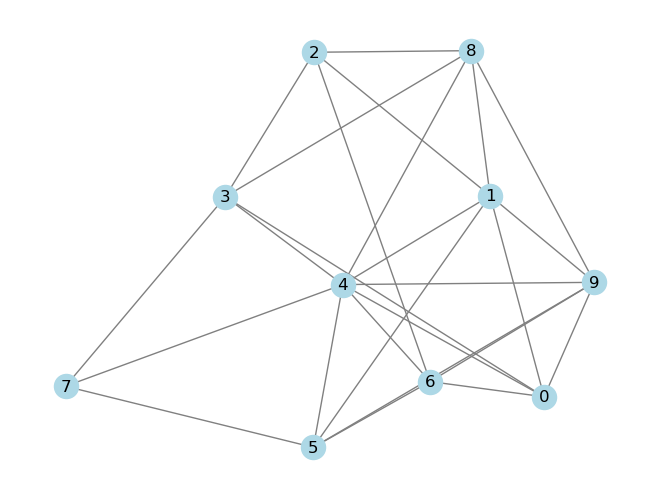

In [35]:
nx_graph = nx.from_numpy_array(G)
# Plot the graph
nx.draw(nx_graph, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [12]:
import os
os.makedirs('MAX-CUT', exist_ok = True)
os.makedirs('MAX-CUT/ER',exist_ok = True)
os.makedirs('MAX-CUT/BA',exist_ok = True)
os.makedirs('MAX-CUT/Watts_Strogatz',exist_ok = True)


In [13]:
import time
from multiprocessing import Process

def process_graph(graph_no,arg):
    model = arg.get('model',None)
    
    number_of_nodes = arg.get('number_of_nodes',None)
    m = arg.get('m',None)
    prob = arg.get('p',None)
    k = arg.get('k',None)

    # Generate adj_matrix in the child process
    G = graph_gen(model=model, n=number_of_nodes, p=prob, m=m, k=k)

    save_folder=f'data/Maximum Cut/{model}'
    os.makedirs(save_folder,exist_ok=True)
    filename=f'{model}{number_of_nodes}_graph{str(graph_no).zfill(3)}.npy'
    file_path=os.path.join(save_folder,filename)
    np.save(file_path,G)
    adj_matrix, weight_matrix, start_list, end_list = flatten_graph(G)
    


    df=defaultdict(list)
    for mul in range(10,510,50):
        
        size_constraint=int(number_of_nodes*mul/1000)

        
        ls_sol, ls_spin,ls_queries= ls_greedy(adj_matrix, weight_matrix, start_list, end_list, size_constraint=size_constraint)
        fls_sol, fls_spin,fls_queries,guided_sol,guided_spin = fls_greedy(adj_matrix, weight_matrix, 
                                                                         start_list, end_list, 
                                                                         size_constraint=size_constraint,
                                                                         error_rate=0.01)
        lee_sol, lee_spin, lee_queries = lee_ls(adj_matrix, weight_matrix, start_list,
                                                                 end_list, size_constraint=size_constraint,
                                                               error_rate=0.1)

        rand_sol, rand_spin,rand_queries= random_greedy(adj_matrix, weight_matrix, start_list,
                                                                 end_list, size_constraint=size_constraint
                                                               )
        
       
        df['graph no'].append(graph_no)
        df['k'].append(size_constraint)
        df['greedy'].append(ls_sol)
        df['fls'].append(fls_sol)
        df['lee'].append(lee_sol)
        df['rand'].append(rand_sol)

        df['greedy_quries'].append(ls_queries)
        df['fls_quries'].append(fls_queries)
        df['lee_quries'].append(lee_queries)
        df['rand_quries'].append(rand_queries)
        
    df=pd.DataFrame(df)
    df.to_pickle(f"MAX-CUT/{model}/{graph_no}.pkl")
        





if __name__ == "__main__":

    # Record the start time using perf_counter()
    from collections import defaultdict
    start_time = time.perf_counter()
    
    
    number_of_graphs = 2
    print(f"Number of graphs:{number_of_graphs}")
    processes = []

    
#     args ={'model':'ER','number_of_nodes':10000,'p':0.001}
#     title = f"Erdős-Rényi Model: {args['number_of_nodes']} Nodes, p={args['p']}"
#     args ={'model':'BA','number_of_nodes':10000,'m':2}
#     title = f"Barabási-Albert Model: {args['number_of_nodes']} Nodes, m={args['m']}"
    args ={'model':'Watts_Strogatz','number_of_nodes':10000,'k':10,'p':0.001}
    title=f"Watts-Strogatz Model: {args['number_of_nodes']} Nodes, k={args['k']}, p={args['p']}"
    


    for graph_no in range(number_of_graphs):
        process = Process(target=process_graph, args=(graph_no,args))
        processes.append(process)
        process.start()

    for process in processes:
        process.join()
        
    

Number of graphs:2


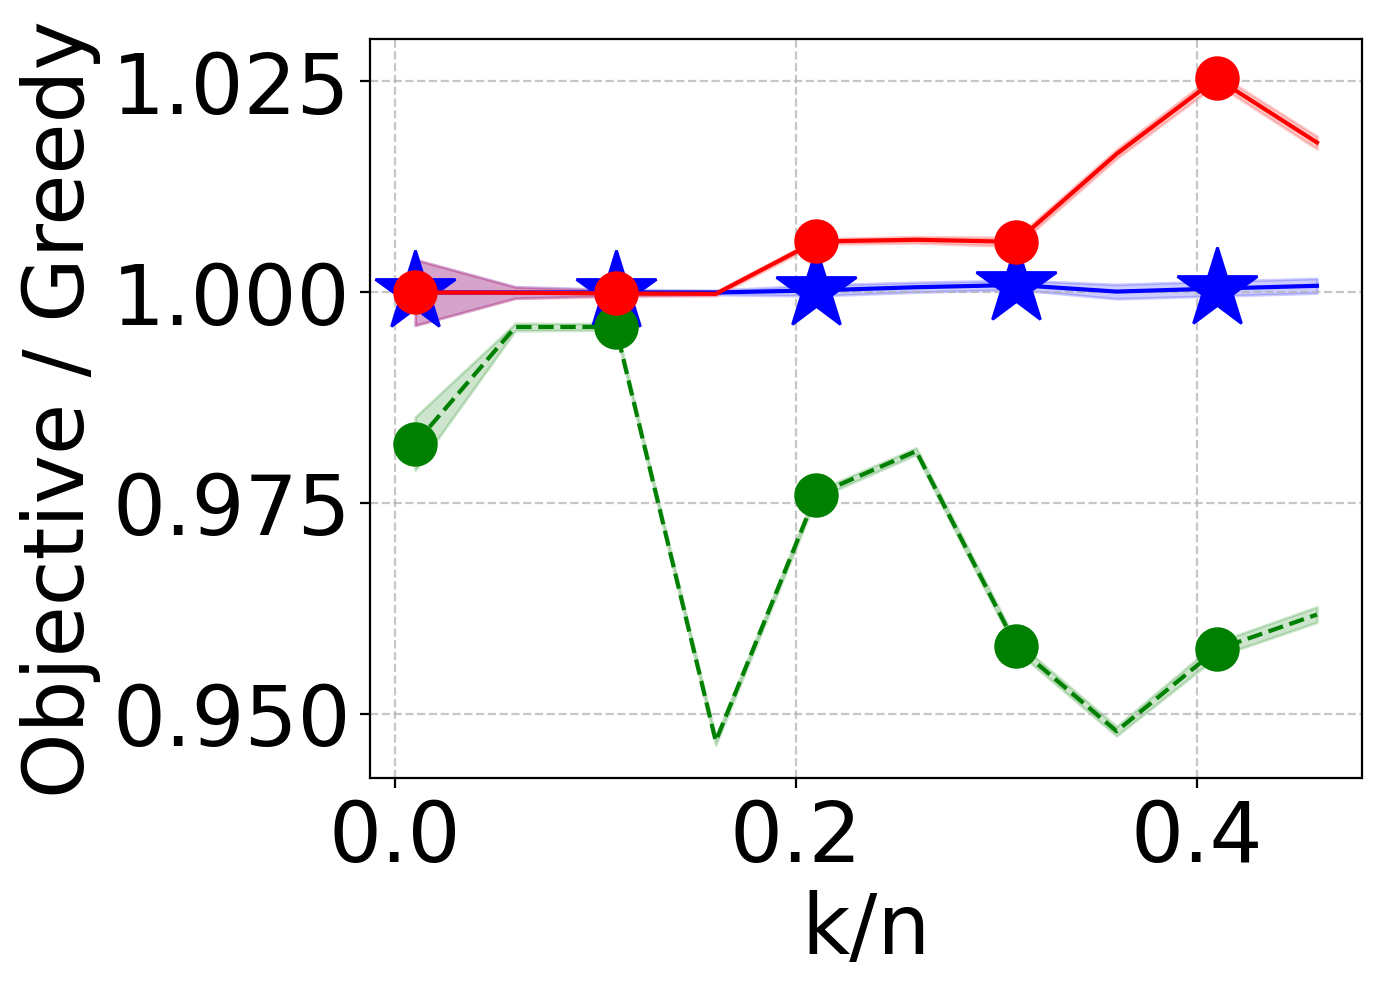

TypeError: LogLocator.set_params() got an unexpected keyword argument 'nbins'

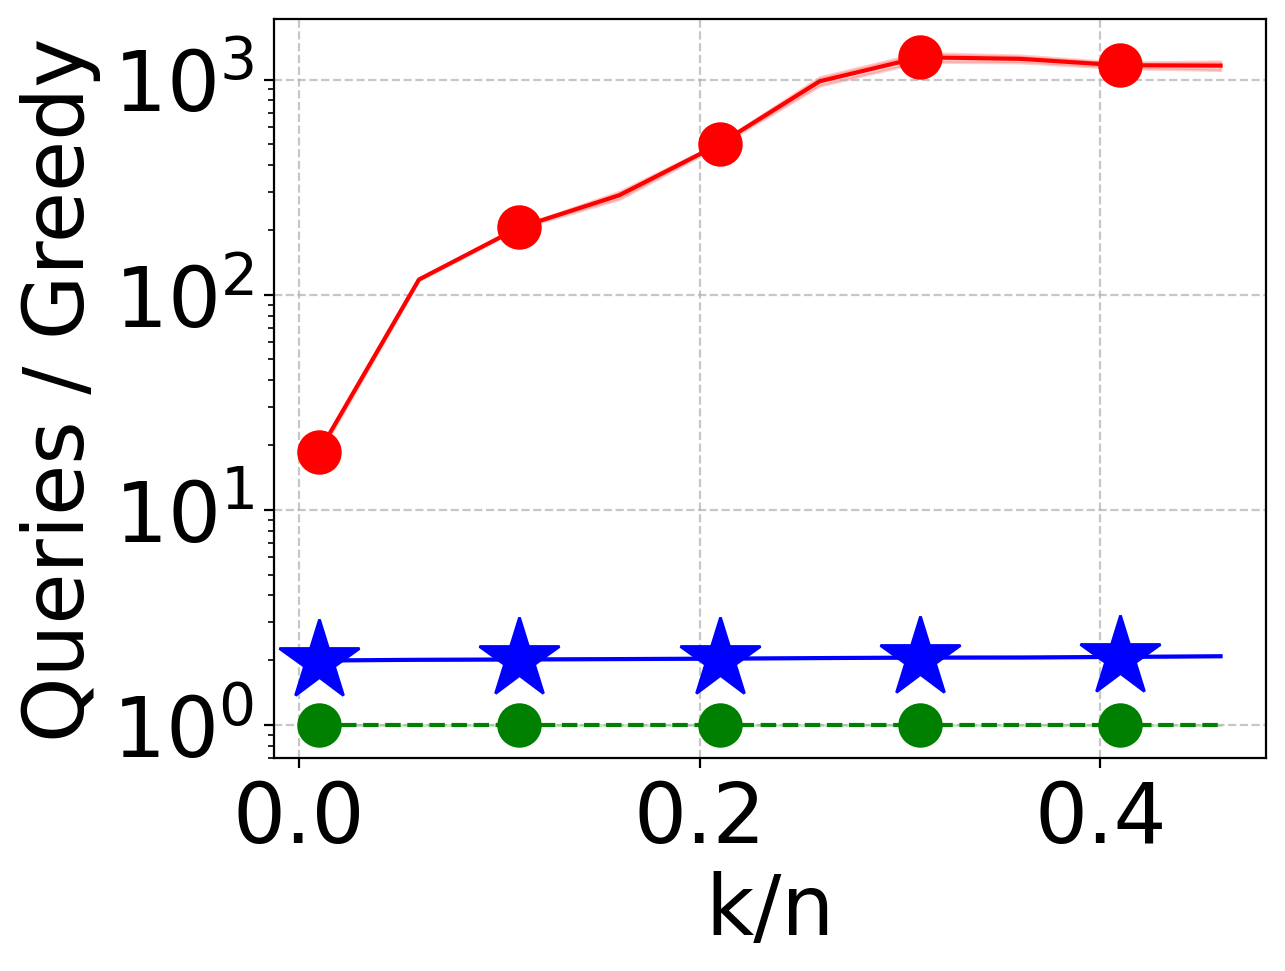

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# model='ER'
# model = 'BA'
model ='Watts_Strogatz'
root_folder = f'Maximum Cut/{model}'
dataframe = None

# Load and concatenate dataframes from pickles in the root folder
for file in os.listdir(root_folder):
    df_loaded = pd.read_pickle(os.path.join(root_folder, file))
    if dataframe is not None:
        dataframe = pd.concat([dataframe, df_loaded], ignore_index=True)
    else:
        dataframe = df_loaded

# Group by 'k' and compute mean and standard deviation
result = dataframe.groupby('k').mean().reset_index()
result_std = dataframe.groupby('k').std().reset_index()

number_of_nodes = 10000

# Plotting the first set of data
plt.figure(dpi=200)

markersize=30
markevery=2

x_label_font_size=y_label_font_size=x_ticks_font_size=y_ticks_font_size=30
legend_fontsize=30

# x_label_font_size=26
# y_label_font_size=26
# x_ticks_font_size= 26
# y_ticks_font_size= 26
# FastLS+GuidedRG
plt.plot(result['k'] / number_of_nodes, result['fls'] / result['greedy'], 
         label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue', markersize=markersize, markevery=markevery)
plt.fill_between(result['k'] / number_of_nodes, 
                 (result['fls'] / result['greedy']) - (result_std['fls'] / result['greedy'] / 2),
                 (result['fls'] / result['greedy']) + (result_std['fls'] / result['greedy'] / 2),
                 color='blue', alpha=0.2)

# Random Greedy
plt.plot(result['k'] / number_of_nodes, result['rand'] / result['greedy'], 
         label='Random Greedy', marker='.', linestyle='--', color='green', markersize=markersize, markevery=markevery)
plt.fill_between(result['k'] / number_of_nodes, 
                 (result['rand'] / result['greedy']) - (result_std['rand'] / result['greedy'] / 2),
                 (result['rand'] / result['greedy']) + (result_std['rand'] / result['greedy'] / 2),
                 color='green', alpha=0.2)

# Lee et al.
plt.plot(result['k'] / number_of_nodes, result['lee'] / result['greedy'], 
         label='Lee et al.', marker='.', linestyle='-', color='red', markersize=markersize, markevery=markevery)
plt.fill_between(result['k'] / number_of_nodes, 
                 (result['lee'] / result['greedy']) - (result_std['lee'] / result['greedy'] / 2),
                 (result['lee'] / result['greedy']) + (result_std['lee'] / result['greedy'] / 2),
                 color='red', alpha=0.2)

# Add labels and title
plt.xlabel('k/n', fontsize=x_label_font_size)
plt.ylabel('Objective / Greedy', fontsize=y_label_font_size)
plt.xticks(fontsize=x_ticks_font_size)
plt.yticks(fontsize=y_ticks_font_size)
# plt.title(model)
if model=='BA':
    plt.legend(loc='lower left', fontsize=legend_fontsize, framealpha=0.0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.locator_params(nbins=4)
plt.savefig(f'ObjectiveMC{model}.pdf', dpi=300, bbox_inches='tight')

plt.show()

# Plotting the second set of data
plt.figure(dpi=200)

# FastLS+GuidedRG Queries
plt.plot(result['k'] / number_of_nodes, result['fls_quries'] / result['greedy_quries'], 
         label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue', markersize=markersize, markevery=markevery)
plt.fill_between(result['k'] / number_of_nodes, 
                 (result['fls_quries'] / result['greedy_quries']) - (result_std['fls_quries'] / result['greedy_quries'] / 2),
                 (result['fls_quries'] / result['greedy_quries']) + (result_std['fls_quries'] / result['greedy_quries'] / 2),
                 color='blue', alpha=0.2)

# Random Queries
plt.plot(result['k'] / number_of_nodes, result['rand_quries'] / result['greedy_quries'], 
         label='Random', marker='.', linestyle='--', color='green', markersize=markersize, markevery=markevery)
plt.fill_between(result['k'] / number_of_nodes, 
                 (result['rand_quries'] / result['greedy_quries']) - (result_std['rand_quries'] / result['greedy_quries'] / 2),
                 (result['rand_quries'] / result['greedy_quries']) + (result_std['rand_quries'] / result['greedy_quries'] / 2),
                 color='green', alpha=0.2)

# Lee et al. Queries
plt.plot(result['k'] / number_of_nodes, result['lee_quries'] / result['greedy_quries'], 
         label='Lee et al.', marker='.', linestyle='-', color='red', markersize=markersize, markevery=markevery)
plt.fill_between(result['k'] / number_of_nodes, 
                 (result['lee_quries'] / result['greedy_quries']) - (result_std['lee_quries'] / result['greedy_quries'] / 2),
                 (result['lee_quries'] / result['greedy_quries']) + (result_std['lee_quries'] / result['greedy_quries'] / 2),
                 color='red', alpha=0.2)

# Add labels and title
plt.xlabel('k/n', fontsize=x_label_font_size)
plt.ylabel('Queries / Greedy', fontsize=y_label_font_size)
plt.xticks(fontsize=x_ticks_font_size)
plt.yticks(fontsize=y_ticks_font_size)
plt.yscale('log')
# plt.legend(loc='lower left', fontsize=26, framealpha=0.0)
# plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=4))
plt.grid(True, linestyle='--', alpha=0.7)
plt.locator_params(nbins=4)
plt.savefig(f'QueriesMC{model}.pdf', dpi=300, bbox_inches='tight')
# plt.title(model)
# Setting the number of ticks 
# plt.locator_params(axis='both', nbins=4) 
plt.show()


In [149]:
result

,k,graph no,greedy,fls,lee,rand,greedy_quries,fls_quries,lee_quries,rand_quries
0,100,9.5,7948.25,7948.05,7948.25,6423.50,1005050.00,1001350.00,6.185975e+07,1005050.0
1,600,9.5,17202.25,17201.20,17206.45,14104.30,5830300.00,5696500.00,1.589790e+09,5830300.0
2,1100,9.5,21325.90,21333.20,21348.50,17601.70,10405550.00,9955650.00,4.321713e+09,10405550.0
3,1600,9.5,23923.45,23948.00,23974.10,19904.80,14730800.00,13778800.00,7.487529e+09,14730800.0
4,2100,9.5,25748.50,25766.60,25830.55,21398.35,18806050.00,17165950.00,1.063184e+10,18806050.0
5,2600,9.5,26923.05,26948.35,27091.90,22508.25,22631300.00,20117100.00,1.256481e+10,22631300.0
6,3100,9.5,27705.05,27896.50,28010.00,23253.60,26206550.00,22632250.00,1.492627e+10,26206550.0
7,3600,9.5,27868.25,28341.25,28478.15,23900.35,27325663.65,24715969.20,1.398738e+10,29531800.0
8,4100,9.5,27868.25,28424.85,28728.85,24611.20,27325663.65,26412339.65,1.096340e+10,32607050.0
9,4600,9.5,27868.25,28412.10,28819.35,25223.85,27325663.65,28484872.05,9.904586e+09,35432300.0


In [15]:
# import time
# from multiprocessing import Process

# def solve(adj_matrix, weight_matrix, start_list, end_list, size_constraint,model,rep):

#     df=defaultdict(list)

#     ls_sol, ls_spin,ls_queries= ls_greedy(adj_matrix, weight_matrix, start_list, end_list, size_constraint=size_constraint)
#     fls_sol, fls_spin,fls_queries,guided_sol,guided_spin = fls_greedy(adj_matrix, weight_matrix, 
#                                                                         start_list, end_list, 
#                                                                         size_constraint=size_constraint,
#                                                                         error_rate=0.01)
#     lee_sol, lee_spin, lee_queries = lee_ls(adj_matrix, weight_matrix, start_list,
#                                             end_list, size_constraint=size_constraint,
#                                             error_rate=0.01)

#     rand_sol, rand_spin,rand_queries= random_greedy(adj_matrix, weight_matrix, start_list,
#                                                                 end_list, size_constraint=size_constraint
#                                                             )
    
    
#     df['k'].append(size_constraint)
#     df['greedy'].append(ls_sol)
#     df['fls'].append(fls_sol)
#     df['lee'].append(lee_sol)
#     df['rand'].append(rand_sol)

#     df['greedy_quries'].append(ls_queries)
#     df['fls_quries'].append(fls_queries)
#     df['lee_quries'].append(lee_queries)
#     df['rand_quries'].append(rand_queries)
        
#     df=pd.DataFrame(df)
#     df.to_pickle(f"MAX-CUT/{model}/{size_constraint}_{rep}.pkl")
        

# if __name__ == "__main__":

#     # Record the start time using perf_counter()
#     from collections import defaultdict
#     start_time = time.perf_counter()
    
    
#     number_of_graphs = 1
#     print(f"Number of graphs:{number_of_graphs}")
#     processes = []

    
# #     args ={'model':'ER','number_of_nodes':10000,'p':0.001}
# #     title = f"Erdős-Rényi Model: {args['number_of_nodes']} Nodes, p={args['p']}"
# #     args ={'model':'BA','number_of_nodes':10000,'m':2}
# #     title = f"Barabási-Albert Model: {args['number_of_nodes']} Nodes, m={args['m']}"
#     args ={'model':'Watts_Strogatz','number_of_nodes':10000,'k':10,'p':0.001}
#     title=f"Watts-Strogatz Model: {args['number_of_nodes']} Nodes, k={args['k']}, p={args['p']}"

#     model = args.get('model',None)
    
#     number_of_nodes = args.get('number_of_nodes',None)
#     m = args.get('m',None)
#     prob = args.get('p',None)
#     k = args.get('k',None)

#     # Generate adj_matrix in the child process
#     G = graph_gen(model=model, n=number_of_nodes, p=prob, m=m, k=k)
#     adj_matrix, weight_matrix, start_list, end_list = flatten_graph(G)

#     np.save(f'{model}.npy', G)
#     processes = []
#     num_rep=10

#     for rep in range(num_rep):
#         for mul in range(10,510,50):
#             size_constraint=int(number_of_nodes*mul/1000)
#             process = Process(target=solve, args=(adj_matrix, weight_matrix, start_list, end_list, 
#                                                         size_constraint,model,rep))
#             processes.append(process)
#             process.start()



#     for process in processes:
#         process.join()
        
    

In [16]:
# import glob

# model='Watts_Strogatz'

# root_folder=f'MAX-CUT/{model}'
# dataframe=None
# for file in os.listdir(root_folder):
#     df_loaded = pd.read_pickle(os.path.join(root_folder,file))
#     if dataframe is not None:
#         dataframe=pd.concat([dataframe,df_loaded], ignore_index=True)
#     else:
#         dataframe=df_loaded 

In [17]:
# mean_fls

In [18]:
# mean_lee

In [19]:
# mean_rand = []
# mean_fls = []
# mean_lee = []

# mean_quieres_rand = []
# mean_quieres_fls = []
# mean_quieres_lee = []

# x_axis = []
# for k, group_df in dataframe.groupby('k'):
#     # Compute mean and std for the group
#     mean = group_df.mean(axis=0)
#     std = group_df.std(axis=0)
    
#     # Append normalized k value
#     x_axis.append(k / number_of_nodes)
    
#     # Append normalized means for 'rand', 'fls', and 'lee' over 'greedy'
#     mean_rand.append(mean['rand'] / mean['greedy'])
#     mean_fls.append(mean['fls'] / mean['greedy'])
#     mean_lee.append(mean['lee'] / mean['greedy'])

#     # Append normalized means for 'rand_quries', 'fls_quries', and 'lee_quries' over 'greedy_quries'
#     mean_quieres_rand.append(mean['rand_quries'] / mean['greedy_quries'])
#     mean_quieres_fls.append(mean['fls_quries'] / mean['greedy_quries'])
#     mean_quieres_lee.append(mean['lee_quries'] / mean['greedy_quries'])

#     # Uncomment if you want to debug and see the means and stds
#     # print(group_df.mean(axis=0))
#     # print(group_df.std(axis=0))

# print(model)
# plt.figure(dpi=200)
# number_of_nodes=10000
# plt.plot(x_axis, 
#          mean_fls, 
#          label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue',markersize=16)
# plt.plot(x_axis, mean_rand, 
#          label='Random Greedy', marker='.', 
#          linestyle='--', color='green',markersize=16)
# plt.plot(x_axis, mean_lee, label='Lee et al.', 
#          marker='.', linestyle='-', color='red',markersize=16)
# # plt.plot(result['k']/number_of_nodes, result['guided_random']/result['greedy'], label='Guided Random Greedy', marker='o', linestyle='-', color='red')
# # plt.plot(result['k'], result['greedy'], label='Greedy', marker='o', linestyle='-', color='red')


# # Add labels and title
# plt.xlabel('k/n',fontsize=26)
# # plt.ylabel('Determinant')
# plt.ylabel('Objective / Greedy',fontsize=26)
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)
# # plt.legend()

# # plt.title(title)

# # # Add a legend
# plt.legend(loc='lower left',fontsize="26", framealpha=0.0)

# # Customize the grid lines
# plt.grid(True, linestyle='--', alpha=0.7)

# # Save the plot to a file (optional)
# plt.savefig(f'ObjectiveMC{model}.pdf', dpi=300,bbox_inches='tight')

# # Show the plot
# plt.show()

# # print(model)
# # plt.figure(dpi=200)
# # number_of_nodes=10000
# # plt.plot(result['k']/number_of_nodes, result['fls_quries']/result['greedy_quries'], 
# #          label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue',markersize=16)
# # plt.plot(result['k']/number_of_nodes, 
# #          result['rand_quries']/result['greedy_quries'], 
# #          label='Random', marker='.', 
# #          linestyle='--', color='green',markersize=16)
# # plt.plot(result['k']/number_of_nodes, 
# #          result['lee_quries']/result['greedy_quries'], 
# #          label='Lee et al.', 
# #          marker='.', linestyle='-', color='red',markersize=16)

# # plt.xlabel('k/n',fontsize=26)
# # # plt.ylabel('Determinant')
# # plt.ylabel('Queries / Greedy',fontsize=26)
# # plt.xticks(fontsize=26)
# # plt.yticks(fontsize=26)

# # # plt.title(title)

# # # # Add a legend
# # # plt.legend(fontsize="16")

# # # Customize the grid lines
# # plt.grid(True, linestyle='--', alpha=0.7)

# # # plt.title(f'Max Cut ER{number_of_nodes} Error Rate {0.1}')

# # # Add a legend
# # # plt.legend()
# # # plt.title(title)
# # # Customize the grid lines
# # plt.grid(True, linestyle='--', alpha=0.7)


# # # Save the plot to a file (optional)
# # plt.savefig(f'QueriesMC{model}.pdf', dpi=300,bbox_inches='tight')

# # # Show the plot
# # plt.show()


In [20]:

# import matplotlib.pyplot as plt

# # dataframe=pd.DataFrame(df)

# # print(title)

# result = dataframe.groupby('k').mean().reset_index()
# # result=result.drop('Graph No', axis=1)
# print(model)
# plt.figure(dpi=200)
# number_of_nodes=10000
# plt.plot(result['k']/number_of_nodes, 
#          result['fls']/result['greedy'], 
#          label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue',markersize=16)
# plt.plot(result['k']/number_of_nodes, result['rand']/result['greedy'], 
#          label='Random Greedy', marker='.', 
#          linestyle='--', color='green',markersize=16)
# plt.plot(result['k']/number_of_nodes, result['lee']/result['greedy'], label='Lee et al.', 
#          marker='.', linestyle='-', color='red',markersize=16)
# # plt.plot(result['k']/number_of_nodes, result['guided_random']/result['greedy'], label='Guided Random Greedy', marker='o', linestyle='-', color='red')
# # plt.plot(result['k'], result['greedy'], label='Greedy', marker='o', linestyle='-', color='red')


# # Add labels and title
# plt.xlabel('k/n',fontsize=26)
# # plt.ylabel('Determinant')
# plt.ylabel('Objective / Greedy',fontsize=26)
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)
# # plt.legend()

# # plt.title(title)

# # # Add a legend
# plt.legend(loc='lower left',fontsize="26", framealpha=0.0)

# # Customize the grid lines
# plt.grid(True, linestyle='--', alpha=0.7)

# # Save the plot to a file (optional)
# plt.savefig(f'ObjectiveMC{model}.pdf', dpi=300,bbox_inches='tight')

# # Show the plot
# plt.show()

# print(model)
# plt.figure(dpi=200)
# number_of_nodes=10000
# plt.plot(result['k']/number_of_nodes, result['fls_quries']/result['greedy_quries'], 
#          label='FastLS+GuidedRG', marker='*', linestyle='-', color='blue',markersize=16)
# plt.plot(result['k']/number_of_nodes, 
#          result['rand_quries']/result['greedy_quries'], 
#          label='Random', marker='.', 
#          linestyle='--', color='green',markersize=16)
# plt.plot(result['k']/number_of_nodes, 
#          result['lee_quries']/result['greedy_quries'], 
#          label='Lee et al.', 
#          marker='.', linestyle='-', color='red',markersize=16)

# plt.xlabel('k/n',fontsize=26)
# # plt.ylabel('Determinant')
# plt.ylabel('Queries / Greedy',fontsize=26)
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)

# # plt.title(title)

# # # Add a legend
# # plt.legend(fontsize="16")

# # Customize the grid lines
# plt.grid(True, linestyle='--', alpha=0.7)

# # plt.title(f'Max Cut ER{number_of_nodes} Error Rate {0.1}')

# # Add a legend
# # plt.legend()
# # plt.title(title)
# # Customize the grid lines
# plt.grid(True, linestyle='--', alpha=0.7)


# # Save the plot to a file (optional)
# plt.savefig(f'QueriesMC{model}.pdf', dpi=300,bbox_inches='tight')

# # Show the plot
# plt.show()